In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./data/train/train.csv')

DHI : 수평면 산란일사량  
DNI : 직달일사량  
WS : 풍속  
RH : 상대습도  
T : 기온  
TARGET : 태양광 발전량  

**point**
- 발전량 & 산란일사량 <=> 직달일사량 & 전일사량
- 발전량 : 습도와 반비례
- 습도와 산란일사량(비례)/직달일사량(반비례) 관계
- 습도로 흐림정도 표현 가능

# 추세그래프

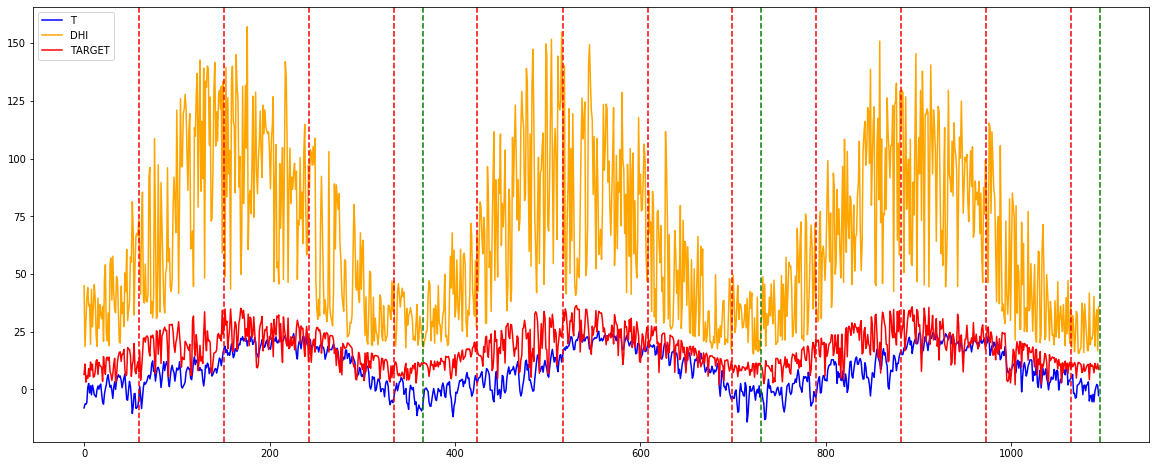

In [3]:
# 계절 나누기

t = train.groupby('Day').mean()
month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄, 여름, 가을, 겨울]

plt.figure(figsize=(20,8))
line1 = plt.plot(t['T'], color='blue', label='T')
line2 = plt.plot(t['DHI'], color='orange', label='DHI')
line3 = plt.plot(t['TARGET'], color='red', label='TARGET')
plt.legend()
m=0
for i in range(3):
    for j in range(5):
        m += month[j]
        if j==4:
            plt.axvline(x=m, color='g', linestyle='--')
        else:
            plt.axvline(x=m, color='r', linestyle='--')
plt.show()

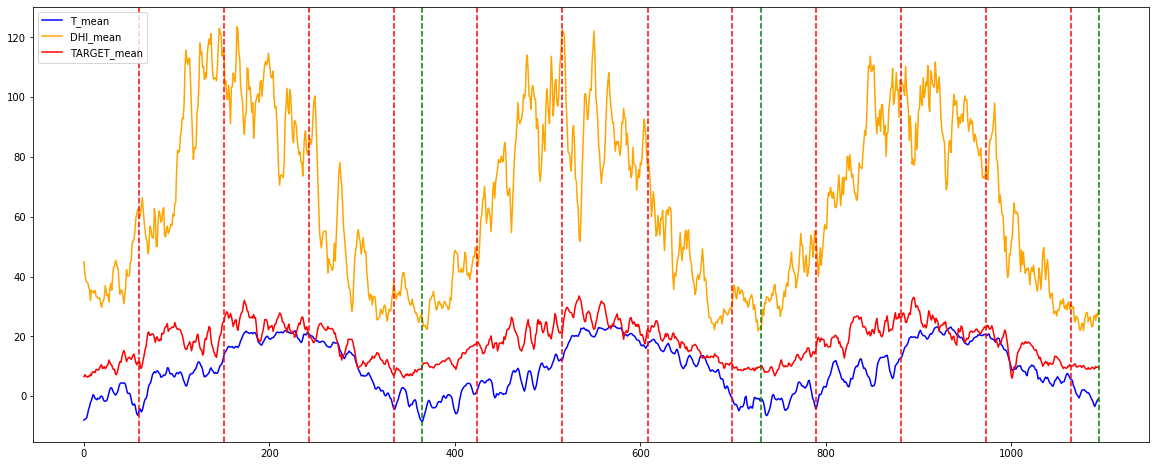

In [4]:
# 계절 판단 기준

df_T = train.groupby('Day').mean()
df_DHI = train.groupby('Day').mean()
df_Target = train.groupby('Day').mean()

for lag in [1,2,3,4,5,6]:
    df_T['T_lag_%s'%lag] = df_T['T'].shift(lag).fillna(method='bfill')
    df_DHI['DHI_lag_%s'%lag] = df_DHI['DHI'].shift(lag).fillna(method='bfill')
    df_Target['Target_lag_%s'%lag] = df_Target['TARGET'].shift(lag).fillna(method='bfill')
    
season = []
for i in range(3):
    year = ['Winter']*month[0] + ['Spring']*month[1] + ['Summer']*month[2] + ['Fall']*month[3] + ['Winter']*month[4]
    season += year
df_T['Season'] = season
df_DHI['Season'] = season
df_Target['Season'] = season

df_T = df_T[['Season', 'T', 'T_lag_1', 'T_lag_2', 'T_lag_3', 'T_lag_4', 'T_lag_5', 'T_lag_6']]
df_DHI = df_DHI[['Season', 'DHI', 'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3', 'DHI_lag_4', 'DHI_lag_5', 'DHI_lag_6']]
df_Target = df_Target[['Season', 'TARGET', 'Target_lag_1', 'Target_lag_2', 'Target_lag_3', 'Target_lag_4', 'Target_lag_5', 'Target_lag_6']]
df_T['T_mean'] = df_T.mean(axis=1)
df_DHI['DHI_mean'] = df_DHI.mean(axis=1)
df_Target['Target_mean'] = df_Target.mean(axis=1)

df_season = pd.DataFrame({'Season' : df_T['Season'], 'T_mean' : df_T['T_mean'], 
                          'DHI_mean' : df_DHI['DHI_mean'], 'Target_mean' : df_Target['Target_mean']}).reset_index(drop=True)

plt.figure(figsize=(20,8))
plt.plot(df_season['T_mean'], color='blue', label='T_mean')
plt.plot(df_season['DHI_mean'], color='orange', label='DHI_mean')
plt.plot(df_season['Target_mean'], color='red', label='TARGET_mean')
plt.legend()
m=0
for i in range(3):
    for j in range(5):
        m += month[j]
        if j==4:
            plt.axvline(x=m, color='green', linestyle='--')
        else:
            plt.axvline(x=m, color='red', linestyle='--')
plt.show()

# Preprocessing (Train)

In [5]:
temp = train.copy()

# 30분 단위로 표현

temp['Minute'] = temp['Minute']/60
temp['Time'] = temp['Hour'] + temp['Minute']


# GHI = DHI + DNI

temp['GHI'] = temp['DHI'] + temp['DNI']


# 계절 변수 생성

month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄_가을, 여름, 봄_가을, 겨울]

season = []
for i in range(3):
    year = ['Winter']*month[0]*48 + ['Spring_Fall']*month[1]*48 + ['Summer']*month[2]*48 + ['Spring_Fall']*month[3]*48 + ['Winter']*month[4]*48
    season += year
    
temp['Season'] = season


train = temp[['TARGET', 'Time', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T', 'Season']]
train

,TARGET,Time,DHI,DNI,GHI,WS,RH,T,Season
0,0.0,0.0,0,0,0,1.5,69.08,-12,Winter
1,0.0,0.5,0,0,0,1.5,69.06,-12,Winter
2,0.0,1.0,0,0,0,1.6,71.78,-12,Winter
3,0.0,1.5,0,0,0,1.6,71.75,-12,Winter
4,0.0,2.0,0,0,0,1.6,75.20,-12,Winter
...,...,...,...,...,...,...,...,...,...
52555,0.0,21.5,0,0,0,2.4,70.70,-4,Winter
52556,0.0,22.0,0,0,0,2.4,66.79,-4,Winter
52557,0.0,22.5,0,0,0,2.2,66.78,-4,Winter
52558,0.0,23.0,0,0,0,2.1,67.72,-4,Winter


In [6]:
train.corr()

,TARGET,Time,DHI,DNI,GHI,WS,RH,T
TARGET,1.000000,0.003805,0.666908,0.833547,0.919257,0.238521,-0.677178,0.561990
Time,0.003805,1.000000,0.029839,-0.018118,-0.008244,-0.056210,-0.083901,0.105184
DHI,0.666908,0.029839,1.000000,0.288294,0.521609,0.203286,-0.478503,0.457813
DNI,0.833547,-0.018118,0.288294,1.000000,0.967337,0.219555,-0.611184,0.402460
GHI,0.919257,-0.008244,0.521609,0.967337,1.000000,0.249444,-0.671251,0.479797
WS,0.238521,-0.056210,0.203286,0.219555,0.249444,1.000000,-0.230035,0.027693
RH,-0.677178,-0.083901,-0.478503,-0.611184,-0.671251,-0.230035,1.000000,-0.532777
T,0.561990,0.105184,0.457813,0.402460,0.479797,0.027693,-0.532777,1.000000


# Preprocessing (Test)

In [7]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    
    
    # 30분 단위로 표현

    temp['Minute'] = temp['Minute']/60
    temp['Time'] = temp['Hour'] + temp['Minute']
    
    
    # GHI = DHI + DNI

    temp['GHI'] = temp['DHI'] + temp['DNI']

    
    df_test.append(temp)

temp = pd.concat(df_test)
test = temp[['TARGET', 'Time', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']].reset_index(drop=True)
test

,TARGET,Time,DHI,DNI,GHI,WS,RH,T
0,0.0,0.0,0,0,0,2.7,34.42,0.0
1,0.0,0.5,0,0,0,2.7,34.17,0.1
2,0.0,1.0,0,0,0,2.7,34.23,0.2
3,0.0,1.5,0,0,0,2.7,33.99,0.3
4,0.0,2.0,0,0,0,2.8,33.97,0.4
...,...,...,...,...,...,...,...,...
27211,0.0,21.5,0,0,0,0.8,63.35,13.7
27212,0.0,22.0,0,0,0,0.7,64.82,13.1
27213,0.0,22.5,0,0,0,0.7,66.10,12.8
27214,0.0,23.0,0,0,0,0.6,67.64,12.4


In [8]:
test.corr()

,TARGET,Time,DHI,DNI,GHI,WS,RH,T
TARGET,1.000000,0.015027,0.659580,0.854636,0.921137,0.248112,-0.684464,0.553646
Time,0.015027,1.000000,0.040794,-0.000268,0.009151,-0.046035,-0.087585,0.103936
DHI,0.659580,0.040794,1.000000,0.329980,0.527260,0.222065,-0.522336,0.485771
DNI,0.854636,-0.000268,0.329980,1.000000,0.976095,0.229108,-0.613814,0.397049
GHI,0.921137,0.009151,0.527260,0.976095,1.000000,0.257353,-0.672769,0.469235
WS,0.248112,-0.046035,0.222065,0.229108,0.257353,1.000000,-0.202408,-0.006883
RH,-0.684464,-0.087585,-0.522336,-0.613814,-0.672769,-0.202408,1.000000,-0.573104
T,0.553646,0.103936,0.485771,0.397049,0.469235,-0.006883,-0.573104,1.000000


# 시간별 그래프

- TARGET과 DHI의 모양이 유사함 => TARGET은 DHI의 영향을 더 받는다.  
- GHI는 DNI와 모양이 유사함 => DNI에 cos고도값을 곱하면 TARGET과 유사한 모양을 가질 것 같다.  

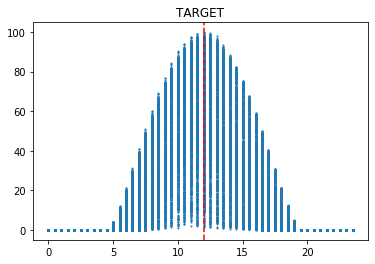

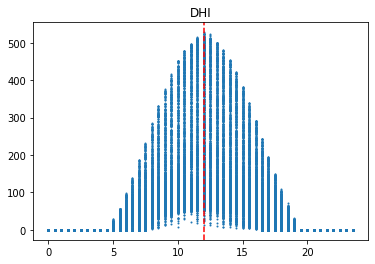

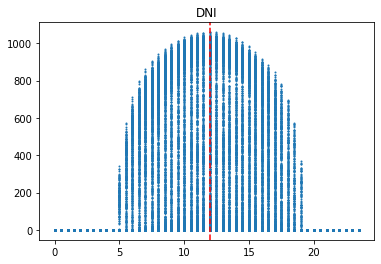

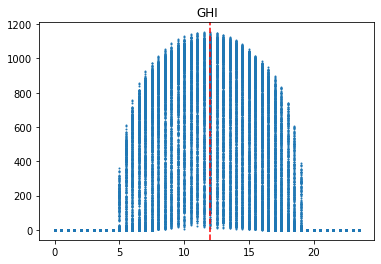

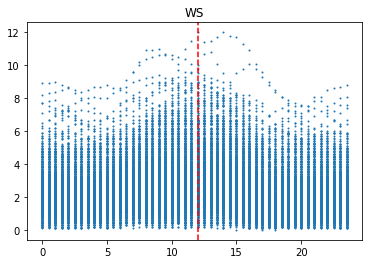

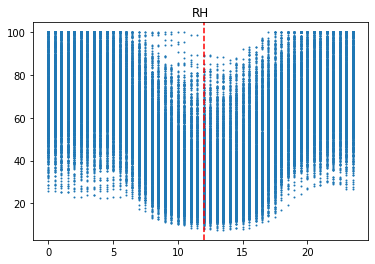

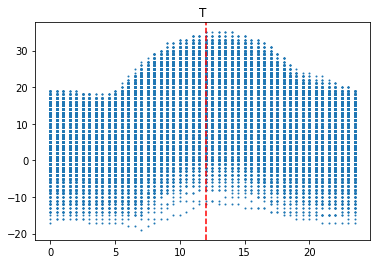

In [9]:
col = ['TARGET', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']

for col in col:
    plt.scatter(train['Time'], train[col], s=1)
    plt.title(col)
    plt.axvline(x=12, color='red', linestyle='--')
    plt.show()

# 기준 습도별 발전량

- 100이 최고 발전량
- 고려사항 : train과 test가 많이 다르다 => test에 맑은날이 많음
- 70 이상을 흐림으로 하는게 좋아보임

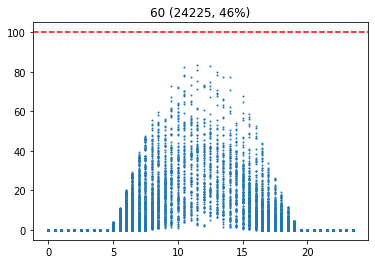

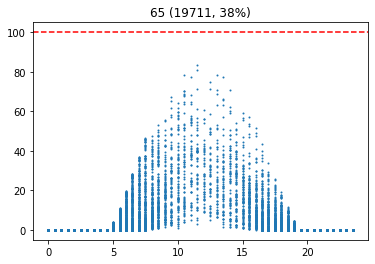

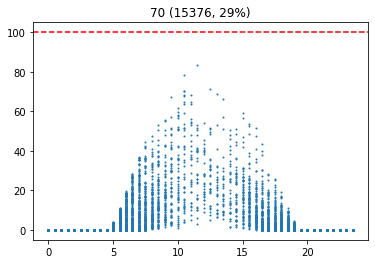

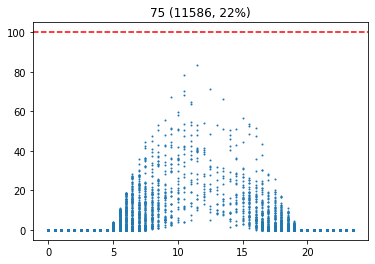

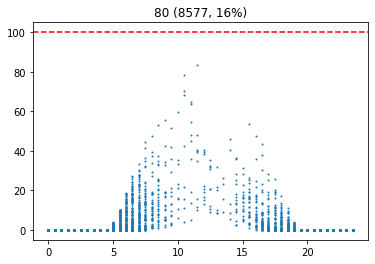

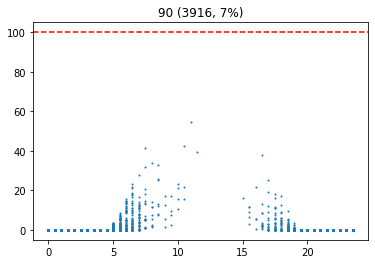

In [10]:
s = [60,65,70,75,80,90]

for s in s:
    plt.scatter(train.loc[train['RH'] >= s]['Time'], train.loc[train['RH'] >= s]['TARGET'], s=1)
    n = len(train.loc[train['RH'] >= s])
    p = round(n/len(train)*100)
    plt.title('%s (%s, %s%%)'%(s,n,p))
    plt.axhline(y=100, color='red', linestyle='--')
    plt.show()

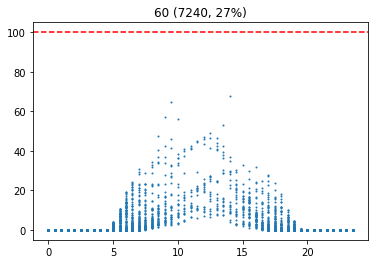

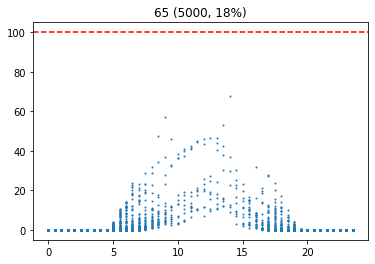

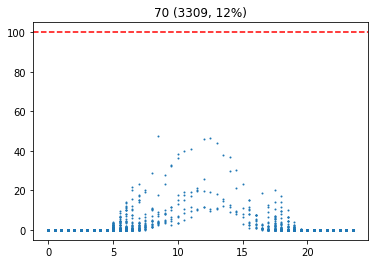

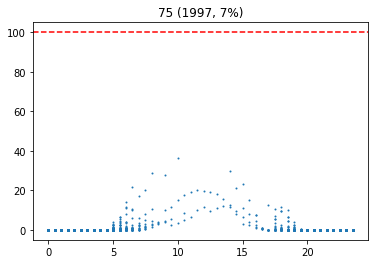

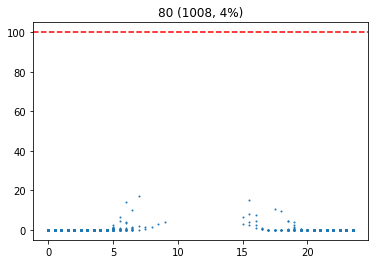

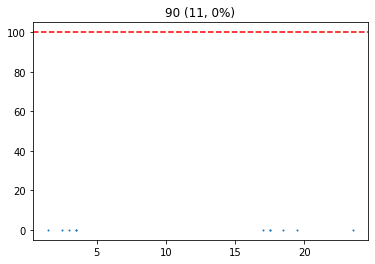

In [11]:
s = [60,65,70,75,80,90]

for s in s:
    plt.scatter(test.loc[test['RH'] >= s]['Time'], test.loc[test['RH'] >= s]['TARGET'], s=1)
    n = len(test.loc[test['RH'] >= s])
    p = round(n/len(test)*100)
    plt.title('%s (%s, %s%%)'%(s,n,p))
    plt.axhline(y=100, color='red', linestyle='--')
    plt.show()

# 발전량

- GHI가 매우 독특하게 나옴 => cos을 적용하면 더 좋아질 것 같다.
- 풍속이 작을땐 발전량 골고루 나옴 / 풍속이 클땐 발전량이 적음
- 습도와 발전량은 반비례
- 기온과 발전량은 비례
- 기온의 train과 test 모양이 다름 (train은 카테고리 느낌)

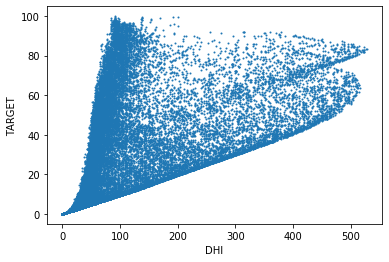

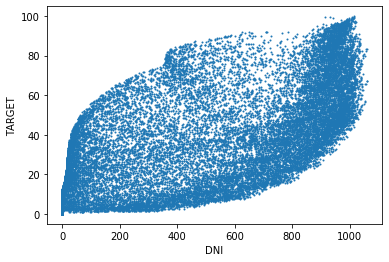

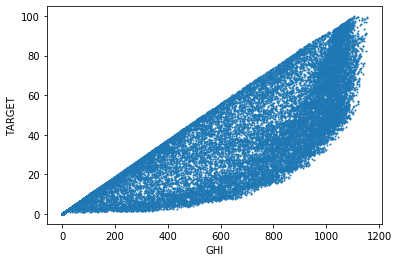

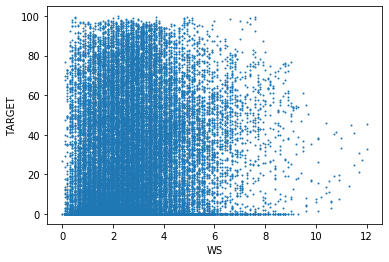

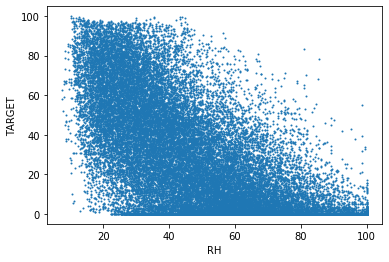

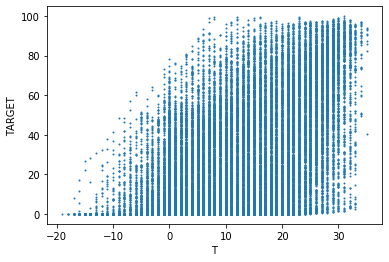

In [12]:
col = ['DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']

for col in col:
    plt.scatter(train[col], train['TARGET'], s=1)
    plt.xlabel(col)
    plt.ylabel('TARGET')
    plt.show()

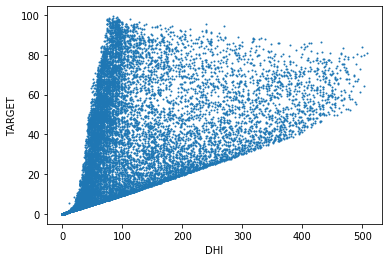

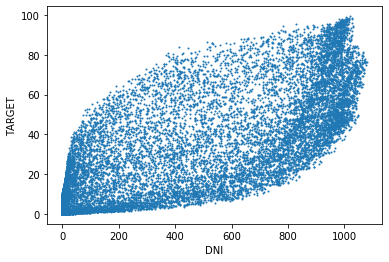

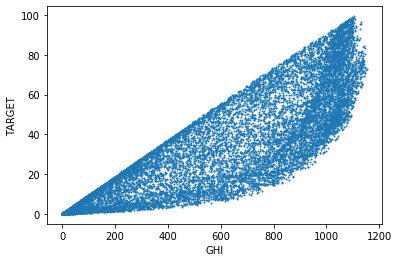

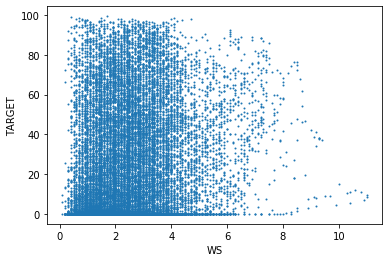

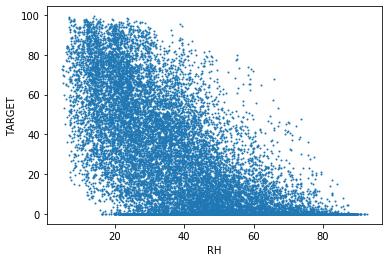

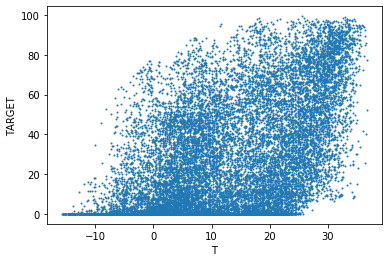

In [13]:
col = ['DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']

for col in col:
    plt.scatter(test[col], test['TARGET'], s=1)
    plt.xlabel(col)
    plt.ylabel('TARGET')
    plt.show()

# 산란일사량

- DHI와 DNI는 반비례 (DHI가 작고, DNI가 큰 곳에 몰려있음)

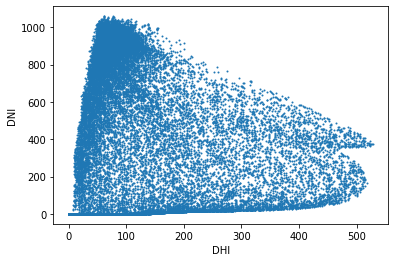

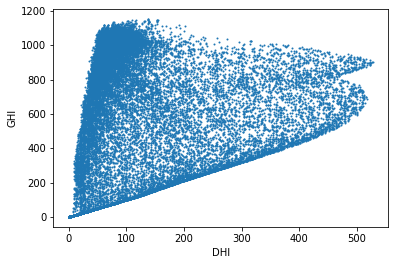

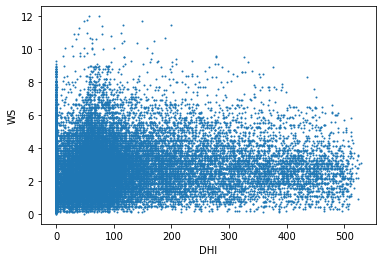

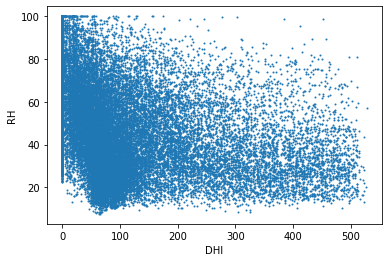

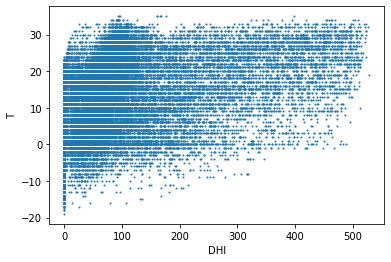

In [14]:
col = ['DNI', 'GHI', 'WS', 'RH', 'T']

for col in col:
    plt.scatter(train['DHI'], train[col], s=1)
    plt.xlabel('DHI')
    plt.ylabel(col)
    plt.show()

# 직달일사량

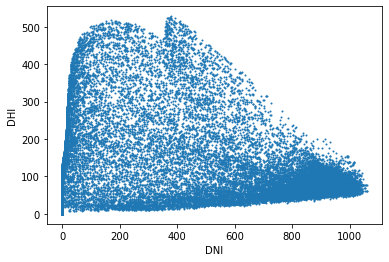

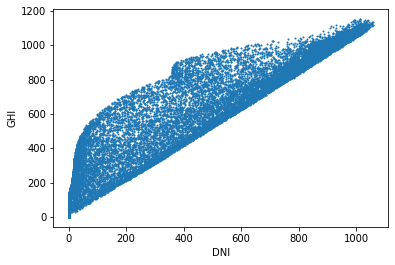

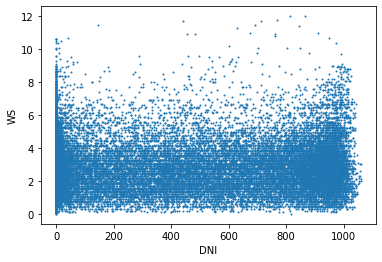

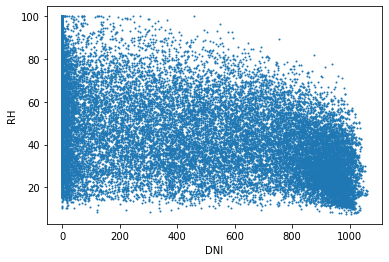

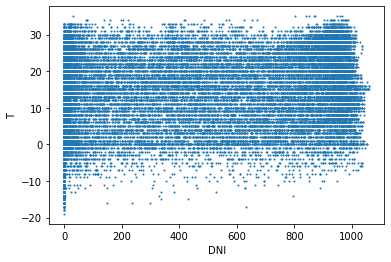

In [15]:
col = ['DHI', 'GHI', 'WS', 'RH', 'T']

for col in col:
    plt.scatter(train['DNI'], train[col], s=1)
    plt.xlabel('DNI')
    plt.ylabel(col)
    plt.show()

# 전일사량

- GHI는 DNI와 유사

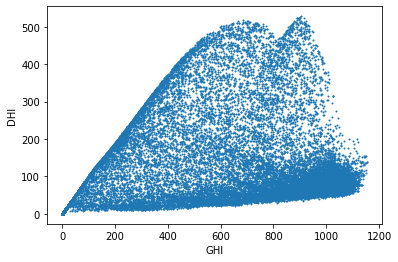

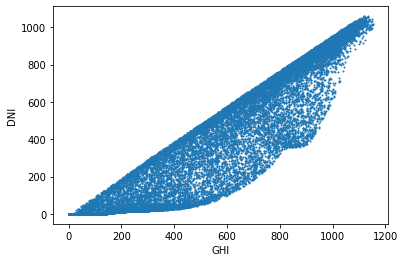

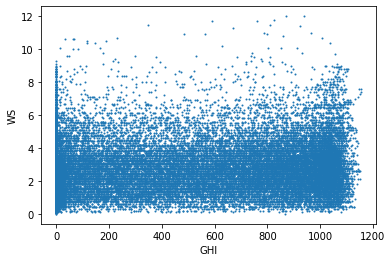

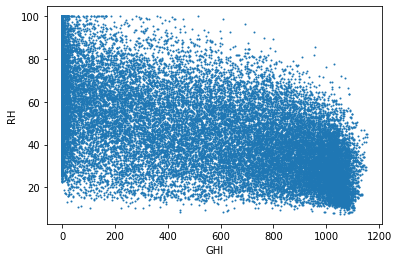

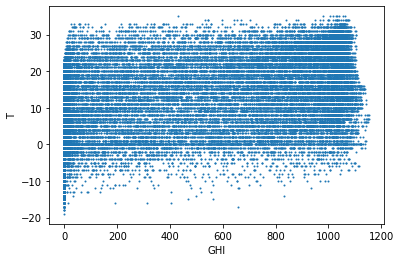

In [16]:
col = ['DHI', 'DNI', 'WS', 'RH', 'T']

for col in col:
    plt.scatter(train['GHI'], train[col], s=1)
    plt.xlabel('GHI')
    plt.ylabel(col)
    plt.show()

# 풍속

- 풍속이 작을때 산란일사량이 작은 경우가 많음
- 풍속이 작을때 직달일사량이 큰 경우가 많음
- 풍속이 작을때 전일사량이 큰 경우가 많음

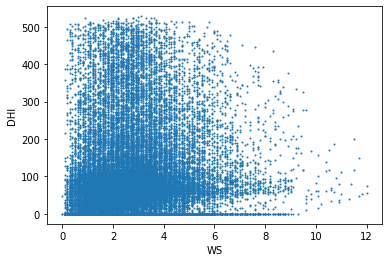

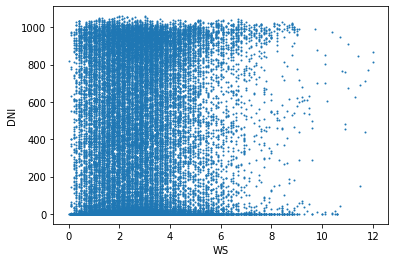

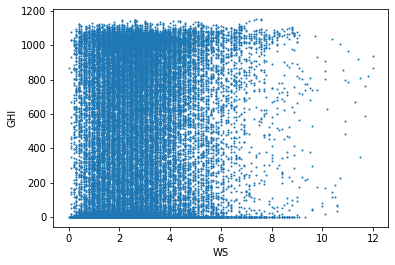

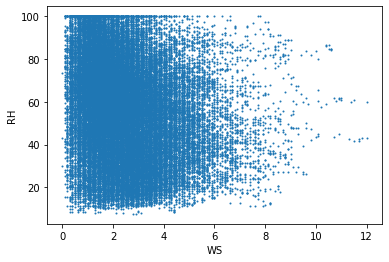

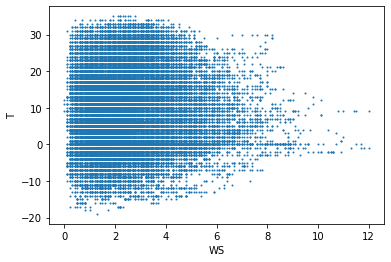

In [17]:
col = ['DHI', 'DNI', 'GHI', 'RH', 'T']

for col in col:
    plt.scatter(train['WS'], train[col], s=1)
    plt.xlabel('WS')
    plt.ylabel(col)
    plt.show()

# 습도

- 습도가 낮으면 산란일사량 작음
- 습도가 낮으면 직달일사량 큼
- 습도와 기온은 반비례

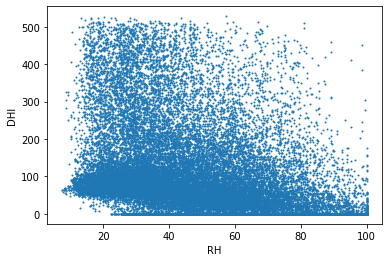

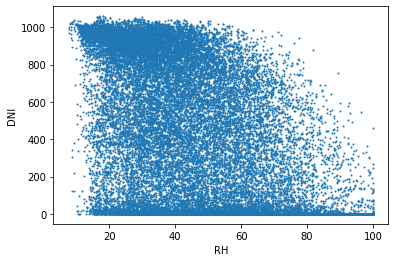

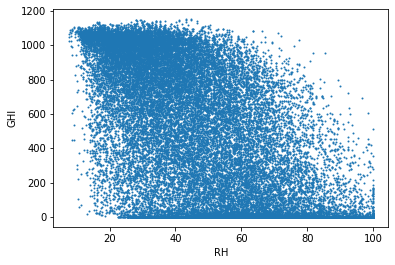

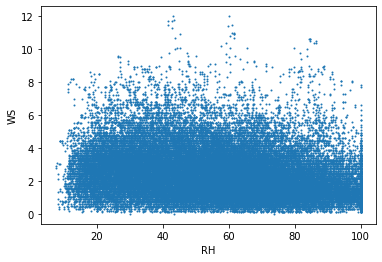

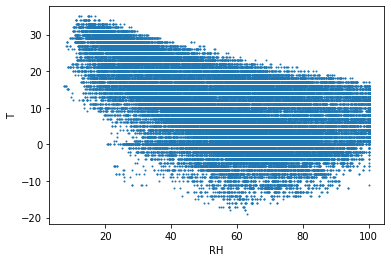

In [18]:
col = ['DHI', 'DNI', 'GHI', 'WS', 'T']

for col in col:
    plt.scatter(train['RH'], train[col], s=1)
    plt.xlabel('RH')
    plt.ylabel(col)
    plt.show()

# 기온

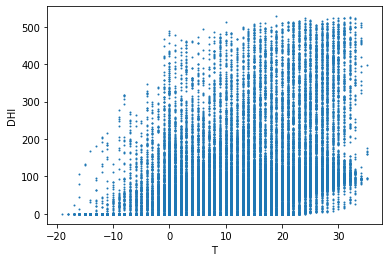

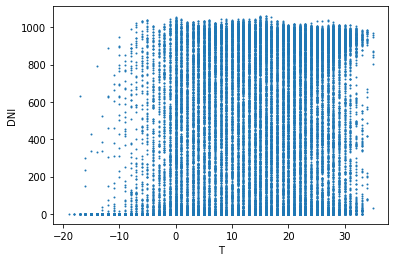

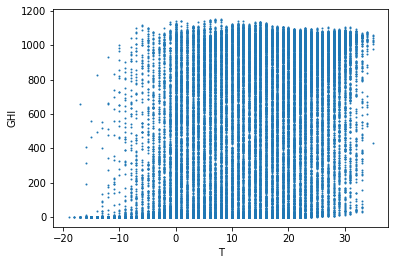

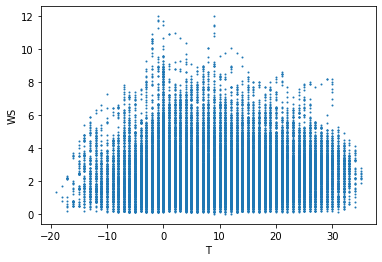

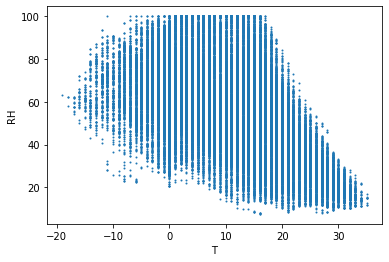

In [19]:
col = ['DHI', 'DNI', 'GHI', 'WS', 'RH']

for col in col:
    plt.scatter(train['T'], train[col], s=1)
    plt.xlabel('T')
    plt.ylabel(col)
    plt.show()